In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch import optim

In [32]:
df = pd.read_excel('results/SA/output_100e.xlsx')
df = df.drop(columns=['neighborhood_size', 'neighbor_deviation_scale', 'vessel_time_window', 'affected_movements', 'time_interval','epochs'])
# rename number of movements to movements reached
df = df.rename(columns={'number of movements': 'movements reached'})
col_names = df.columns
print(col_names)

Index(['instance', 'movements reached', 'median delay', 'average delay',
       'obj_val', 't0', 'alpha', 'valid_solution'],
      dtype='object')


In [33]:
df_instances = pd.read_excel('results/instanceData_200.xlsx')
col_names_instances = df_instances.columns
print(col_names_instances)
# merge the two dataframes
df = pd.merge(df, df_instances, on='instance')

Index(['instance', 'number_of_movements', 'number_of_headways',
       'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
       'average_time_between_movements', 'average_travel_time'],
      dtype='object')


In [34]:
# recalculate the objective function
movements_factor = 0.001
headway_factor = 0.001
df['objective_function'] = df['average delay'] \
                           + df['movements reached'] * movements_factor + df['number_of_headways'] * headway_factor
print(df['objective_function'], df['average delay'])

0      1.469833
1      1.424000
2      1.140667
3      1.278167
4      1.007333
         ...   
995    0.971667
996    0.938333
997    1.758333
998    1.005000
999    0.701667
Name: objective_function, Length: 1000, dtype: float64 0      1.045833
1      1.000000
2      0.716667
3      0.854167
4      0.583333
         ...   
995    0.346667
996    0.313333
997    1.133333
998    0.380000
999    0.076667
Name: average delay, Length: 1000, dtype: float64


In [40]:
feature_cols= ['t0', 'alpha',
               'number_of_movements', 'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
                'average_time_between_movements', 'average_travel_time']

data = torch.tensor(df.values)

X = data[feature_cols].values
y = data['objective_function'].values

In [53]:
# prepare the data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# also scale the y data
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# pytorch expects the data to be in the form of tensors
# convert the data to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# batch the data
train_tensor = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=4, shuffle=True)


## batch the data, this is not used
#train_tensor = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
#train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=4, shuffle=True)

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 18)
        self.fc2 = nn.Linear(18, 36)
        # Adjust the next layers to match the output size of fc2
        self.fc3 = nn.Linear(36, 750)  # Adjusted the size here
        self.fc4 = nn.Linear(750, 36)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  # Reintroduce fc3 here
        x = self.fc4(x)
        x = x.view(x.size(0), -1)
        return x

net = Net()
# to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(net)

Net(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=36, bias=True)
  (fc3): Linear(in_features=36, out_features=18, bias=True)
  (fc4): Linear(in_features=750, out_features=36, bias=True)
)


In [43]:
# define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [52]:
epochs = 100
loss_arr = []

for i in range(epochs):
    y_hat = net.forward(X_train_tensor)
    loss = criterion(y_hat, y_train_tensor)
    loss_arr.append(loss)


    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (750x36 and 750x36)

In [49]:
# train an ann regression model
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)



NameError: name 'train_loader' is not defined

In [44]:

regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=0)

In [45]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = regr.predict(X_test)
print('Accuracy: ', regr.score(X_test, y_test))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Accuracy:  0.47078877604131353
Mean squared error: 0.06


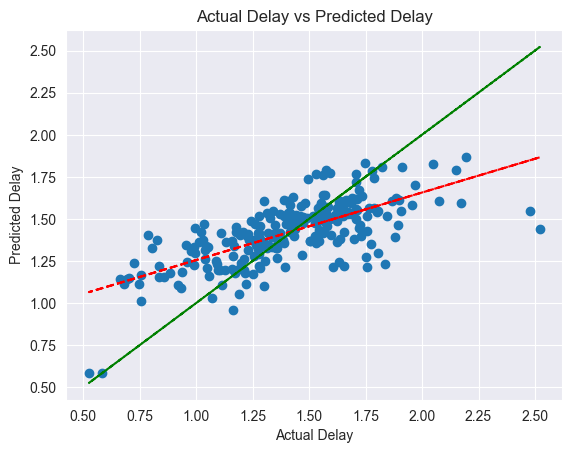

In [46]:
# graph the predicted delay vs the actual delay
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Delay')
plt.ylabel('Predicted Delay')
plt.title("Actual Delay vs Predicted Delay")
# plot the line of best fit
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"r--")
# plot the line y=x
plt.plot(y_test, y_test, 'g--')
plt.show()

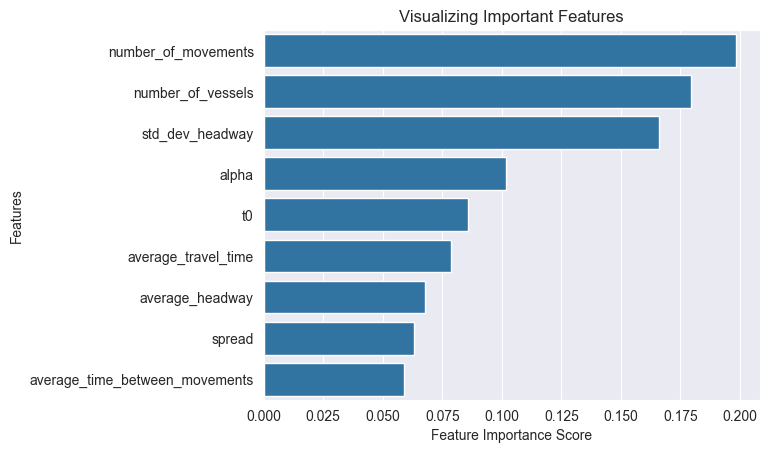

In [47]:
# create a graph of the feature importance
feature_imp = pd.Series(regr.feature_importances_, index=feature_cols).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()